## MNIST CNN (LeNET)

In [1]:
import tensorflow as tf
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### MNIST dataset reading pipeline

In [7]:
p = Path('./datasets/MNIST_data/') 
train_images_path = p / 'train-images.idx3-ubyte'
train_label_path = p / 'train-labels.idx1-ubyte'
test_images_path = p / 't10k-images.idx3-ubyte'
test_label_path = p / 't10k-labels.idx1-ubyte'

def mnist_dataset(train:bool) -> tf.data.Dataset:
    if train:
        #4 byte offset for 4 numbers
        im = tf.data.FixedLengthRecordDataset([str(train_images_path)],28*28,header_bytes=16)
        #4 byte offset for 2 numbers
        label = tf.data.FixedLengthRecordDataset([str(train_label_path)],1,header_bytes=8)        
    else:
        im = tf.data.FixedLengthRecordDataset([str(test_images_path)],28*28,header_bytes=16)
        label = tf.data.FixedLengthRecordDataset([str(test_label_path)],1,header_bytes=8)
        
    im = im.map(lambda x: tf.decode_raw(x,tf.uint8),num_parallel_calls=4)
    im = im.map(lambda x: tf.reshape(x,(28,28,1)),num_parallel_calls=4) 
    im = im.map(lambda x: tf.image.convert_image_dtype(x,tf.float32),num_parallel_calls=4)
    im = im.map(lambda x: tf.image.resize_images(x,(32,32)))
    
    label = label.map(lambda x: tf.decode_raw(x,tf.uint8), num_parallel_calls=4)
    label = label.map(lambda x: tf.one_hot(x,10), num_parallel_calls=4)
    
    dataset = tf.data.Dataset.zip((im,label))
        
    return dataset

with tf.device('/cpu:0'):
    train_dataset = mnist_dataset(True)
    train_dataset = train_dataset.shuffle(20000)
    train_dataset = train_dataset.repeat(10)
    train_dataset = train_dataset.batch(10)
    train_dataset = train_dataset.prefetch(2)
    
with tf.device('/cpu:0'):
    test_dataset = mnist_dataset(False)
    test_dataset = test_dataset.batch(10)
    test_dataset = test_dataset.prefetch(2)
    
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,train_dataset.output_shapes)
model_input,label = iterator.get_next()

training_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

**Check**

In [8]:
with tf.Session() as sess:
    sess.run(test_init_op)
    i,l = sess.run([model_input,label])

In [9]:
i.shape

(10, 32, 32, 1)

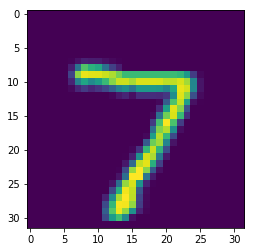

In [10]:
plt.imshow(i[0].reshape(32,32))

### Building LE-net

<img src="pics/lenet.jpg" width=600px />

**Calculating CNN output shape**: (Same folrmula applies for pooling too)

> **out_W** = ((Width - Filter_W + 2xPadding)/stride_W) + 1

> **out_H** = ((Height - Filter_H + 2xPadding)/stride_H) + 1

In [11]:
model_input.shape

TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(1)])

**Convolition 1**

In [18]:
conv1 = tf.layers.conv2d(model_input,6,(5,5),(1,1),activation=tf.nn.tanh)

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(conv1)

In [20]:
o.shape #(32-5)/1. + 1 = 28

(10, 28, 28, 6)

**Average pool 1**

In [21]:
avgpool1 = tf.layers.average_pooling2d(conv1,(2,2),(2,2))

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(avgpool1)
o.shape #(28-2)/2. + 1 = 14

(10, 14, 14, 6)

**Convolution 2**

In [23]:
conv2 = tf.layers.conv2d(avgpool1,16,(5,5),(1,1),activation=tf.nn.tanh)

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(conv2)
o.shape# (14-5)/1. + 1 = 10

(10, 10, 10, 16)

**Average pool 2**

In [25]:
avgpool2 = tf.layers.average_pooling2d(conv2,(2,2),(2,2))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(avgpool2)
o.shape #(10-2)/2. + 1 = 5

(10, 5, 5, 16)

**Convolution 3**

In [26]:
conv3 = tf.layers.conv2d(avgpool2,120,(5,5),(1,1),activation=tf.nn.tanh)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(conv3)
o.shape #(5-5)/1. + 1 = 1

(10, 1, 1, 120)

**Flatten**

In [27]:
flatten = tf.layers.Flatten()(conv3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(flatten)
o.shape

(10, 120)

### CNN features

In [28]:
def cnn_features(model_input):
    
    conv1 = tf.layers.conv2d(model_input,6,(5,5),(1,1),activation=tf.nn.tanh)
    avgpool1 = tf.layers.average_pooling2d(conv1,(2,2),(2,2))
    
    conv2 = tf.layers.conv2d(avgpool1,16,(5,5),(1,1),activation=tf.nn.tanh)
    avgpool2 = tf.layers.average_pooling2d(conv2,(2,2),(2,2))
    
    conv3 = tf.layers.conv2d(avgpool2,120,(5,5),(1,1),activation=tf.nn.tanh)
    
    flatten = tf.layers.Flatten()(conv3)
    
    features = tf.layers.dense(flatten,84,activation=tf.nn.tanh)
    
    return features

In [29]:
features = cnn_features(model_input)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(features)
o.shape

(10, 84)

### Classifier

> We have the classifier separate, so that the features can be finetunes on some other dataset

In [30]:
classifier = tf.layers.dense(features,10)

In [32]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(test_init_op)
    o = sess.run(classifier)
o

array([[-0.06158399, -0.00125845, -0.0380252 ,  0.0482185 ,  0.11377073,
        -0.04729971,  0.03703606, -0.14200684,  0.02212132,  0.00433373],
       [-0.0819338 ,  0.02448411, -0.10021084,  0.04427387,  0.06867027,
        -0.07757335,  0.18205622, -0.04480159,  0.07955201,  0.10961425],
       [ 0.05541191, -0.01347145, -0.04798395, -0.03188056,  0.09555981,
         0.00900401,  0.10916211, -0.04232593, -0.04049245,  0.03779127],
       [-0.12691906, -0.06379687, -0.05380139,  0.11359388,  0.13446128,
        -0.10716493,  0.08703112, -0.14577502,  0.0660833 ,  0.02137068],
       [-0.02304949,  0.05611792, -0.02910851,  0.11060248,  0.08766459,
        -0.06275809, -0.00780628, -0.09804662,  0.08089873, -0.05021089],
       [ 0.05454372, -0.01559561, -0.0602768 , -0.03158849,  0.13172951,
        -0.01539958,  0.14186162, -0.0725493 , -0.03956236,  0.05747043],
       [ 0.02804943,  0.10268132, -0.15091434,  0.03082578,  0.15652929,
        -0.003925  , -0.00372341, -0.20401523

### Training

In [33]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=label,logits=classifier))
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

In [ ]:
!rm models/MNIST_CNN/*

In [34]:
import time
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(training_init_op)

    start = time.time()
    try:
        i = 1
        tmp = []
        while True:
            i = i+1
            l,_ = sess.run([loss,train])
            tmp.append(l)
            if i%5000 == 0:
                avg_loss = np.array(tmp).mean()
                print("Batch: ",i,avg_loss)
                tmp = []
                
    except tf.errors.OutOfRangeError:
        pass
    
    end = time.time()
    elapsed = end-start
    print("Elapsed time : ", elapsed, " s")
    saver.save(sess,'models/MNIST_CNN/mnist_model.ckpt')

Batch:  5000 0.3912253
Batch:  10000 0.15127452
Batch:  15000 0.0963868
Batch:  20000 0.07276272
Batch:  25000 0.061499048
Batch:  30000 0.05317923
Batch:  35000 0.045373138
Batch:  40000 0.040958915
Batch:  45000 0.036442723
Batch:  50000 0.03284309
Batch:  55000 0.030515958
Batch:  60000 0.02779906
Elapsed time :  71.61451387405396  s


### Evaluation

In [36]:
def get_accuracy(predict:'eg: [2,4,1,...]',true: 'eg: [2,4,1,...]') -> int:
    correct_pred = tf.equal(predict,true)
    #We have to cast [True,False,True,...] --> [1,0,1...]
    acc = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    return acc

with tf.Session() as sess:
    saver.restore(sess,'models/MNIST_CNN/mnist_model.ckpt')
    sess.run(test_init_op)
    
    #IMPORTANT:
    #Dont place this code inside the loop! This will slow down everything
    acc = get_accuracy(tf.argmax(classifier,axis=1),tf.transpose(tf.argmax(label,axis=2)))
    
    try:
        i = 0
        acc_list = []
        while True:
            i = i+1
            a = sess.run(acc)
            acc_list.append(a)
            if i%100 == 0:
                print(i, "Mean Acc : ", np.array(acc_list).mean())
                acc_list = []
                           
    except tf.errors.OutOfRangeError:
        pass    

INFO:tensorflow:Restoring parameters from models/MNIST_CNN/mnist_model.ckpt
100 Mean Acc :  0.988
200 Mean Acc :  0.97900003
300 Mean Acc :  0.9779999
400 Mean Acc :  0.99
500 Mean Acc :  0.98100007
600 Mean Acc :  0.995
700 Mean Acc :  0.99
800 Mean Acc :  0.998
900 Mean Acc :  0.997
1000 Mean Acc :  0.989
